In [25]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

In [26]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [27]:
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')
# Pull pricing data for 3 more BTC exchanges
# ADD YALE/SPCOMP
exchanges = ['COINBASE','BITSTAMP','ITBIT']


exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    if exchange == 'SPCOMP':
        exchange_code = 'YALE/{}'.format(exchange)
    else:    
        exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Loaded BCHARTS/KRAKENUSD from cache
Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [28]:
df = exchange_data['KRAKEN']
print(df.head())

                 Open       High        Low      Close  Volume (BTC)  \
Date                                                                   
2014-01-07  874.67040  892.06753  810.00000  810.00000     15.622378   
2014-01-08  810.00000  899.84281  788.00000  824.98287     19.182756   
2014-01-09  825.56345  870.00000  807.42084  841.86934      8.158335   
2014-01-10  839.99000  857.34056  817.00000  857.33056      8.024510   
2014-01-11  858.20000  918.05471  857.16554  899.84105     18.748285   

            Volume (Currency)  Weighted Price  
Date                                           
2014-01-07       13151.472844      841.835522  
2014-01-08       16097.329584      839.156269  
2014-01-09        6784.249982      831.572913  
2014-01-10        6780.220188      844.938794  
2014-01-11       16698.566929      890.671709  


In [29]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime

In [30]:
style.use('ggplot')


df = df[['Open',  'High',  'Low',  'Close', 'Volume (BTC)']]
df['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

C:\Users\Luisk8nj\Documents\Anaconda\envs\PythonData\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [31]:
df = df[['Close', 'HL_PCT', 'PCT_change', 'Volume (BTC)']]
forecast_col = 'Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

In [20]:

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)

forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

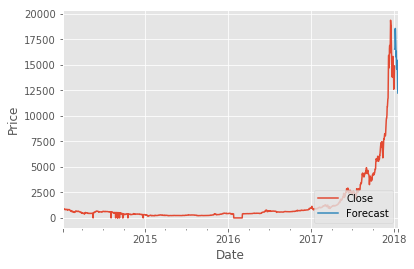

In [21]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

df['Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [22]:
df['Forecast'].tail()

Date
2018-01-13    15452.772635
2018-01-14    14851.720016
2018-01-15    14833.265091
2018-01-16    12757.237488
2018-01-17    12226.055674
Name: Forecast, dtype: float64

In [23]:
data = [go.Scatter(x=df.index, y=df.Close)]

py.iplot(data)

In [24]:
trace_high = go.Scatter(
                x=df.index,
                y=df['Close'],
                name = "Close",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

trace_low = go.Scatter(
                x=df.index,
                y=df['Forecast'],
                name = "Forecast",
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)

data = [trace_high,trace_low]

layout = dict(
    title = "Bitcoin Closing Prices",
    xaxis = dict(
        range = ['2014-07-01','2018-2-28'])
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Bitcoin Closing Prices")